# Geodesic Runtime

In [502]:
import jax.numpy as jnp

import os

import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from tabulate import tabulate

In [503]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [574]:
geometry = "riemannian"
T = 100
path = f'timing/{geometry}/'
manifold = "Sphere"
figure_path = '../figures/geodesic_runtime/'

In [575]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading Values

In [576]:
save_path = ''.join((path, manifold, '/'))

In [577]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]

In [578]:
estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    dim = file.replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    estimates[dim] = values

## Table Comparison

In [509]:
dims = list(estimates.keys())

mu_time = [estimates[key3][key2]['mu_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
std_time = [estimates[key3][key2]['std_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
length = [estimates[key3][key2]['length'] for key3,v3 in estimates.items()for key2,v2 in v3.items()]
iter_num = [estimates[key3][key2]['iterations'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
grad_norm = [estimates[key3][key2]['grad_norm'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
error = []
for key3, v3 in estimates.items():
    for key2, v2 in v3.items():
        val = estimates[key3][key2]
        if "error" in val.keys():
            error.append(val['error'])
        else:
            error.append(None)
max_iter = [estimates[key3][key2]['max_iter'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
tol = [estimates[key3][key2]['tol'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
method = [key2 for key3,v3 in estimates.items() for key2,v2 in v3.items()]
dims = [key3 for key3,v3 in estimates.items() for key2,v2 in v3.items()]

N_methods = len(list(set(method)))
#dims = sum([[d]*N_methods for d in dims], [])

In [510]:
names = [r"Dim", r"Method", #r"Error",
        r"Length", r"Iterations", r"grad_norm", r"mean time",
        r"std time", r"max_iter", r"tol"]

table_dict = {}
table_dict['Dim'] = dims
table_dict['Method'] = method
#table_dict['Error'] = error
table_dict['Length'] = length
table_dict['Iterations'] = iter_num
table_dict['grad_norm'] = grad_norm
table_dict['mu_time'] = mu_time
table_dict['std_time'] = std_time
table_dict['max_iter'] = max_iter
table_dict['tol'] = tol

print(tabulate(table_dict, headers=names, floatfmt=".4f"))


  Dim  Method          Length    Iterations    grad_norm    mean time    std time    max_iter     tol
-----  ------------  --------  ------------  -----------  -----------  ----------  ----------  ------
    2  ground_truth
    2  GEORCE          9.0475     1000.0000       5.2857      12.4996      0.0074        1000  0.0001
    2  init            8.7469                                                            1000  0.0001
    2  ADAM            7.2683     1000.0000       1.0114       0.7200      0.0063        1000  0.0001
    2  SGD           inf           186.0000     nan            0.1323      0.0008        1000  0.0001
    2  BFGS            7.0816       98.0000       2.4899     492.6898     25.2512        1000  0.0001
    2  CG              8.0535       31.0000     106.9218     200.5290      0.8208        1000  0.0001
    2  dogleg          9.0475        0.0000       5.2857       4.2557      0.1093        1000  0.0001
    2  trust-ncg       8.7777       49.0000      66.2457     3

### Printing Table Version of Table

In [511]:
#methods = ['BFGS', 'ADAM', 'GEORCE']
#methods = ['SGD', 'CG', 'dogleg']
methods = ['trust-ncg', 'trust-exact']

In [512]:
dims = [int(key3) for key3, v3 in estimates.items()]
dims.sort()
dims = [str(d) for d in dims]

In [513]:
def manifold_str(d):
    
    if manifold == "Sphere":
        return "\mathbb{S}^{"+f"{d}"+"}"
    elif manifold == "Ellipsoid":
        return "\mathrm{E}\\left( "+f"{d}"+" \\right)"
    elif manifold == "SPDN":
        return "\mathcal{P}\\left( "+f"{d}"+" \\right)"
    elif manifold == "T2":
        return "\mathbb{T}^{"+f"{d}"+"}"
    
    

In [514]:
for d in dims:
    print(f"${manifold_str(d)}$", end="")
    length = []
    iters = []
    mu_times = []
    std_times = []
    for m in methods:
        if m in estimates[d].keys():
            length.append(estimates[d][m]['length'])
            iters.append(estimates[d][m]['iterations'])
            mu_times.append(estimates[d][m]['mu_time'])
            std_times.append(estimates[d][m]['std_time'])
        else:
            length.append(jnp.nan)
            iters.append(jnp.nan)
            mu_times.append(jnp.nan)
            std_times.append(jnp.nan)
    length = jnp.stack(length)
    iters = jnp.stack(iters)
    mu_times = jnp.stack(mu_times)
    std_times = jnp.stack(std_times)
    best_length = jnp.where(length == jnp.nanmin(length))[0]
    best_iters = jnp.where(iters == jnp.nanmin(iters))[0]
    best_times = jnp.where(mu_times == jnp.nanmin(mu_times))[0]
    for i in range(len(length)):
        if jnp.isnan(length[i]):
            l = '-'
            it = '-'
            mu_time = '-'
            std_time = '-'
            print(f" & ${l}$", end="")
            print(f" & ${it}$", end="")
            print(f" & $-$", end="")
        else:
            if i in best_length:
                print(f" & $\\pmb{{{length[i]:.4f}}}$", end="")
            else:
                print(f" & ${length[i]:.4f}$", end="")
            if i in best_iters:
                print(f" & $\\pmb{{{int(iters[i])}}}$", end="")
            else:
                print(f" & ${int(iters[i])}$", end="")
            if i in best_times:
                print(f" & $\\pmb{{{mu_times[i]:.4f}}} \pm \\pmb{{ {std_times[i]:.4f} }}$", end="")
            else:
                print(f" & ${mu_times[i]:.4f} \pm {std_times[i]:.4f}$", end="")
    print(" \\\ ")

$\mathbb{T}^{2}$ & $\pmb{8.7777}$ & $\pmb{49}$ & $\pmb{342.4721} \pm \pmb{ 1.1208 }$ & $-$ & $-$ & $-$ \\ 


## Plotting Comparison

In [515]:
methods = [list(estimates[k].keys()) for k,v in estimates.items()]

IndexError: list index out of range

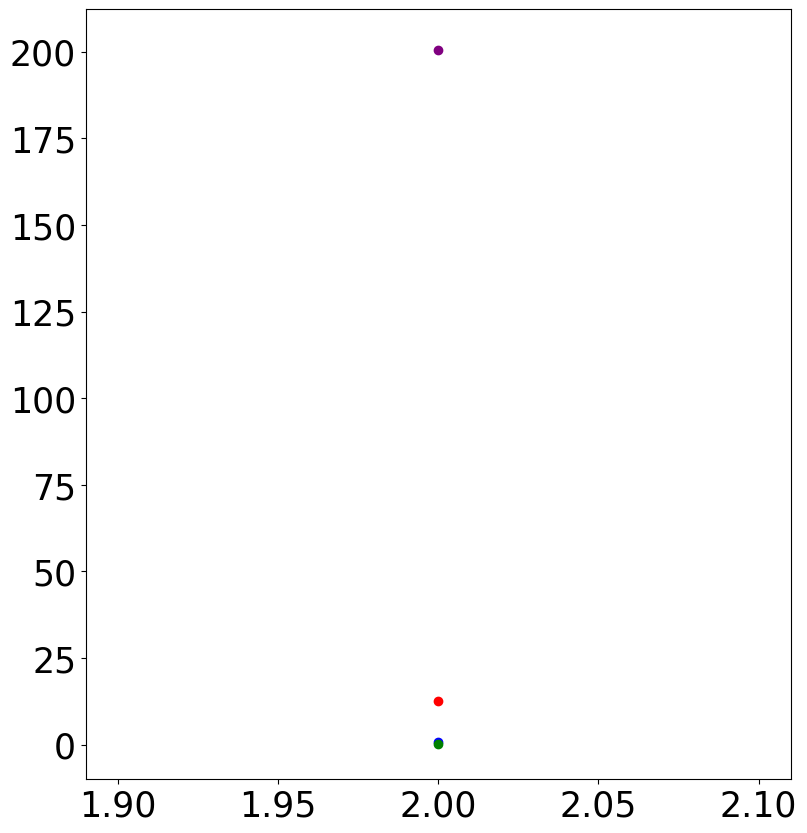

In [516]:
color = ['red', 'blue', 'green', 'purple']

fig = plt.figure(figsize=(20,10))
i_last = len(methods)-1

ax = fig.add_subplot(121)
for i in range(len(methods)):
    n_dims = methods[i]
    j = 0
    for m in n_dims:
        if not (m=="BFGS" or m=="ground_truth" or m=="init"):
            mu_time = [estimates[key3][key2]['mu_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items() if key2==m]
            std_time = [estimates[key3][key2]['std_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items() if key2==m]
            dims = [int(key3) for key3,v3 in estimates.items()]
            dims.sort()
            mu_time = [x for _, x in sorted(zip(dims, mu_time))]
            std_time = [x for _, x in sorted(zip(dims, std_time))]
            mu_time, std_time, dims = jnp.stack(mu_time), jnp.stack(std_time), jnp.stack(dims)
            ax.plot(dims, mu_time, '-o', color=color[j])
            ax.fill_between(
                            dims,
                            jnp.maximum(mu_time - 1.96 * std_time, 
                                        jnp.zeros_like(mu_time)),
                            jnp.maximum(mu_time + 1.96 * std_time, 
                                        jnp.zeros_like(mu_time)),
                            alpha=0.1,
                        )
            j += 1
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Time (s)')
ax.grid(True)

ax = fig.add_subplot(122)
for i in range(len(methods)):
    n_dims = methods[i]
    j = 0
    for m in n_dims:
        if not (m=="BFGS" or m=="ground_truth" or m=="init"):
            mu_time = [estimates[key3][key2]['length'] for key3,v3 in estimates.items() for key2,v2 in v3.items() if key2==m]
            dims = [int(key3) for key3,v3 in estimates.items()]
            dims.sort()
            mu_time = [x for _, x in sorted(zip(dims, mu_time))]
            if i == i_last:
                ax.plot(dims, mu_time, '-o', label=m, color=color[j])
            else:
                ax.plot(dims, mu_time, '-o', color=color[j])
            j += 1
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Geodesic Length')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.2), ncol=5)

plt.show()

save_path = f'{figure_path}{manifold}_runtime.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

## Plotting $\mathbb{S}^{n}$ and Ellipsoid(n) for $T=100$

In [585]:
geometry = "riemannian"
T = 100
path = f'timing/{geometry}/'
figure_path = '../figures/geodesic_runtime/'

In [586]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading $\mathbb{S}^{n}$

In [587]:
manifold = "Sphere"
save_path = ''.join((path, f"{manifold}", '/'))

In [588]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]

In [589]:
sphere_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    dim = file.replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    sphere_estimates[dim] = values

## Loading Ellipsoid(n)

In [591]:
manifold = "Ellipsoid"
save_path = ''.join((path, f"{manifold}", '/'))

In [592]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]

In [593]:
ellipsoid_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    dim = file.replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    ellipsoid_estimates[dim] = values

## Table Comparison

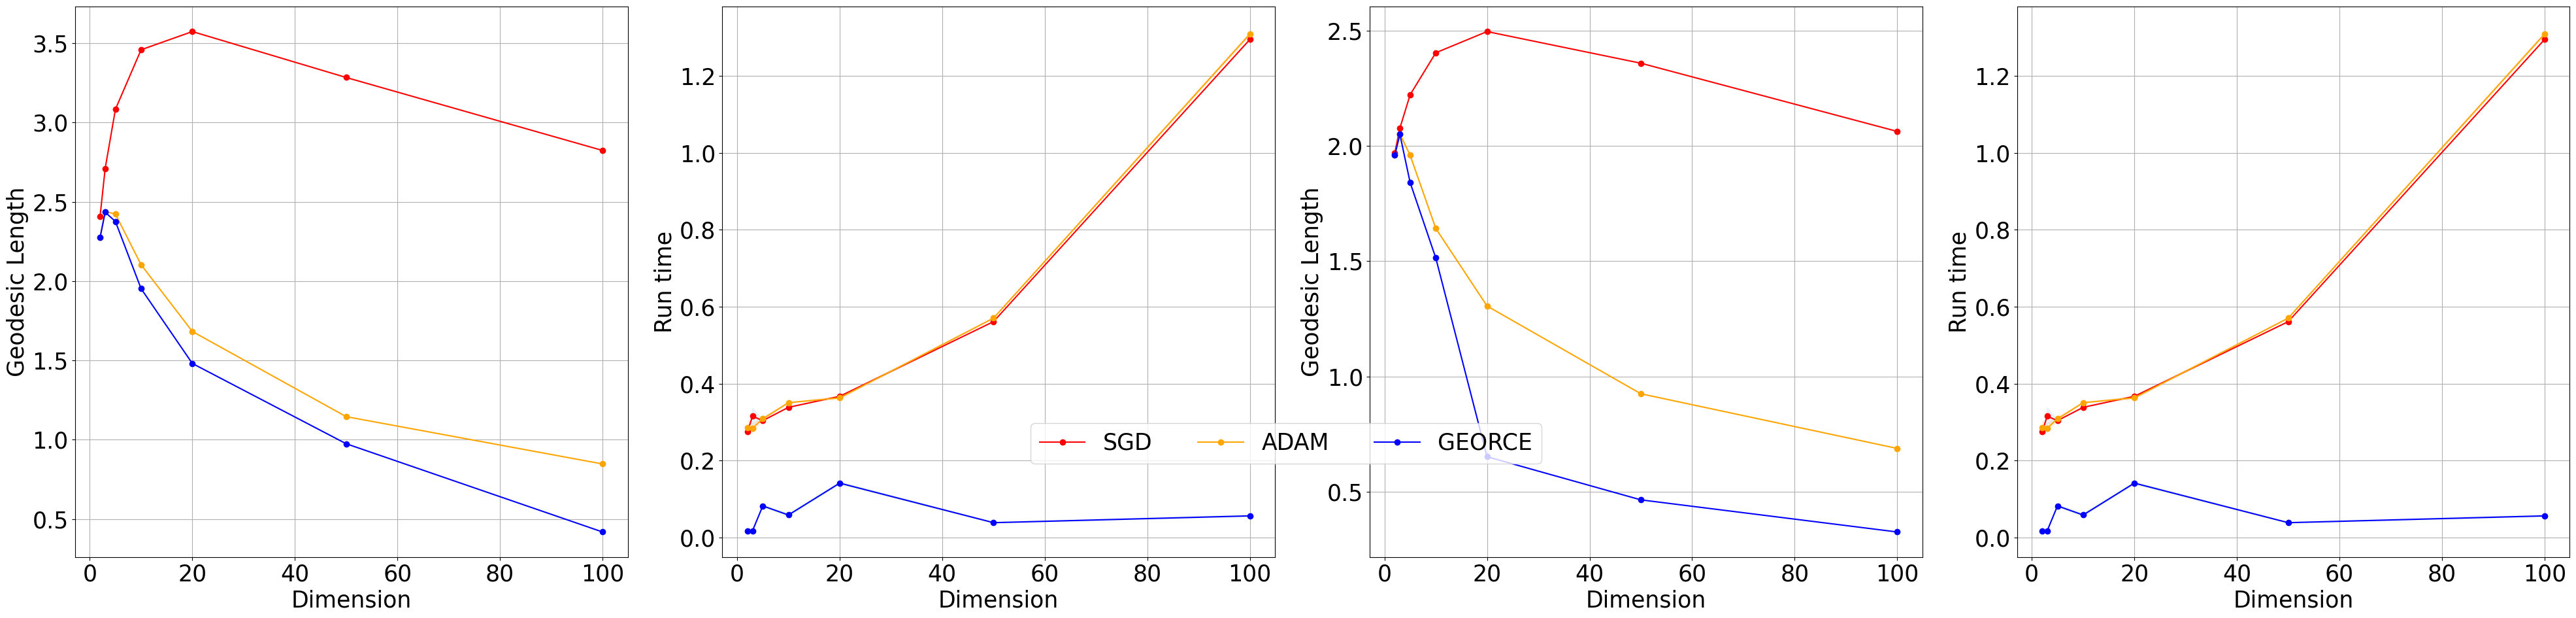

In [618]:
color = ['red', 'orange', 'blue']
methods = ['SGD', 'ADAM', 'GEORCE']
dims = [2,3,5,10,20,50,100]

fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(141)
for j in range(len(methods)):
    vals = []
    for d in dims:
        if 'length' in sphere_estimates[str(d)][methods[j]].keys():
            vals.append(sphere_estimates[str(d)][methods[j]]['length'])
        else:
            vals.append(jnp.nan)
    vals = jnp.stack(vals)
    ax.plot(dims, vals, '-o', color=color[j])
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Geodesic Length')
ax.grid(True)
    
ax = fig.add_subplot(142)
for j in range(len(methods)):
    vals = []
    vals2 = []
    for d in dims:
        if 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys():
            vals.append(ellipsoid_estimates[str(d)][methods[j]]['mu_time'])
            vals2.append(ellipsoid_estimates[str(d)][methods[j]]['std_time'])
        else:
            vals.append(jnp.nan)
            vals2.append(jnp.nan)
    vals = jnp.stack(vals)
    vals2 = jnp.stack(vals2)
    ax.plot(dims, vals, '-o', color=color[j])
    ax.fill_between(
                    dims,
                    jnp.maximum(vals - 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    jnp.maximum(vals + 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    alpha=0.1,
                )
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Run time')
ax.grid(True)

ax = fig.add_subplot(143)
for j in range(len(methods)):
    vals = []
    for d in dims:
        if 'length' in ellipsoid_estimates[str(d)][methods[j]].keys():
            vals.append(ellipsoid_estimates[str(d)][methods[j]]['length'])
        else:
            vals.append(jnp.nan)
    vals = jnp.stack(vals)
    ax.plot(dims, vals, '-o', color=color[j])
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Geodesic Length')
ax.grid(True)
    
ax = fig.add_subplot(144)
for j in range(len(methods)):
    vals = []
    vals2 = []
    for d in dims:
        if 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys():
            vals.append(ellipsoid_estimates[str(d)][methods[j]]['mu_time'])
            vals2.append(ellipsoid_estimates[str(d)][methods[j]]['std_time'])
        else:
            vals.append(jnp.nan)
            vals2.append(jnp.nan)
    vals = jnp.stack(vals)
    vals2 = jnp.stack(vals2)
    ax.plot(dims, vals, '-o', color=color[j], label=methods[j])
    ax.fill_between(
                    dims,
                    jnp.maximum(vals - 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    jnp.maximum(vals + 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    alpha=0.1,
                )
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Run time')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.40,0.25), ncol=5)



fig.tight_layout()

plt.show()

save_path = f'{figure_path}sphere_ellipsoid_runtime.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')